In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import operator
%matplotlib inline
sns.set_style('dark')


import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from scipy.stats import shapiro


import warnings
warnings.simplefilter(action='ignore', category=Warning)

pal = ['#00246d', '#2492b6', '#93c9db', '#93c9db', '#2492b6', '#00246d']

In [2]:
df = pd.read_csv('data/kc_house_data_cleaned.csv')
df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  waterfront  view  \
0  221900         3       1.00         1180      5650           0     0   
1  538000         3       2.25         2570      7242           0     0   
2  180000         2       1.00          770     10000           0     0   
3  604000         4       3.00         1960      5000           0     0   
4  510000         3       2.00         1680      8080           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7        1180              0      1955             0   
1          3      7        2170            400      1951          1991   
2          3      6         770              0      1933             0   
3          5      7        1050            910      1965             0   
4          3      8        1680              0      1987             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  basement  renovated  
0    98178  47.5112 -122.257           1340        5650         0          0  
1    98125  47.7210 -122.319           1690        7639         1          1  
2    98028  47.7379 -122.233           2720        8062         0          0  
3    98136  47.5208 -122.393           1360        5000         1          0  
4    98074  47.6168 -122.045           1800        7503         0          0

### Correlation Heatmap

In [3]:
def show_corr_matrix(df):
    data_corr = df.corr()
    plt.figure(figsize=(25,8),dpi=100)
    mask = np.triu(np.ones_like(data_corr, dtype=np.int))
    sns.heatmap(data_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap=pal)

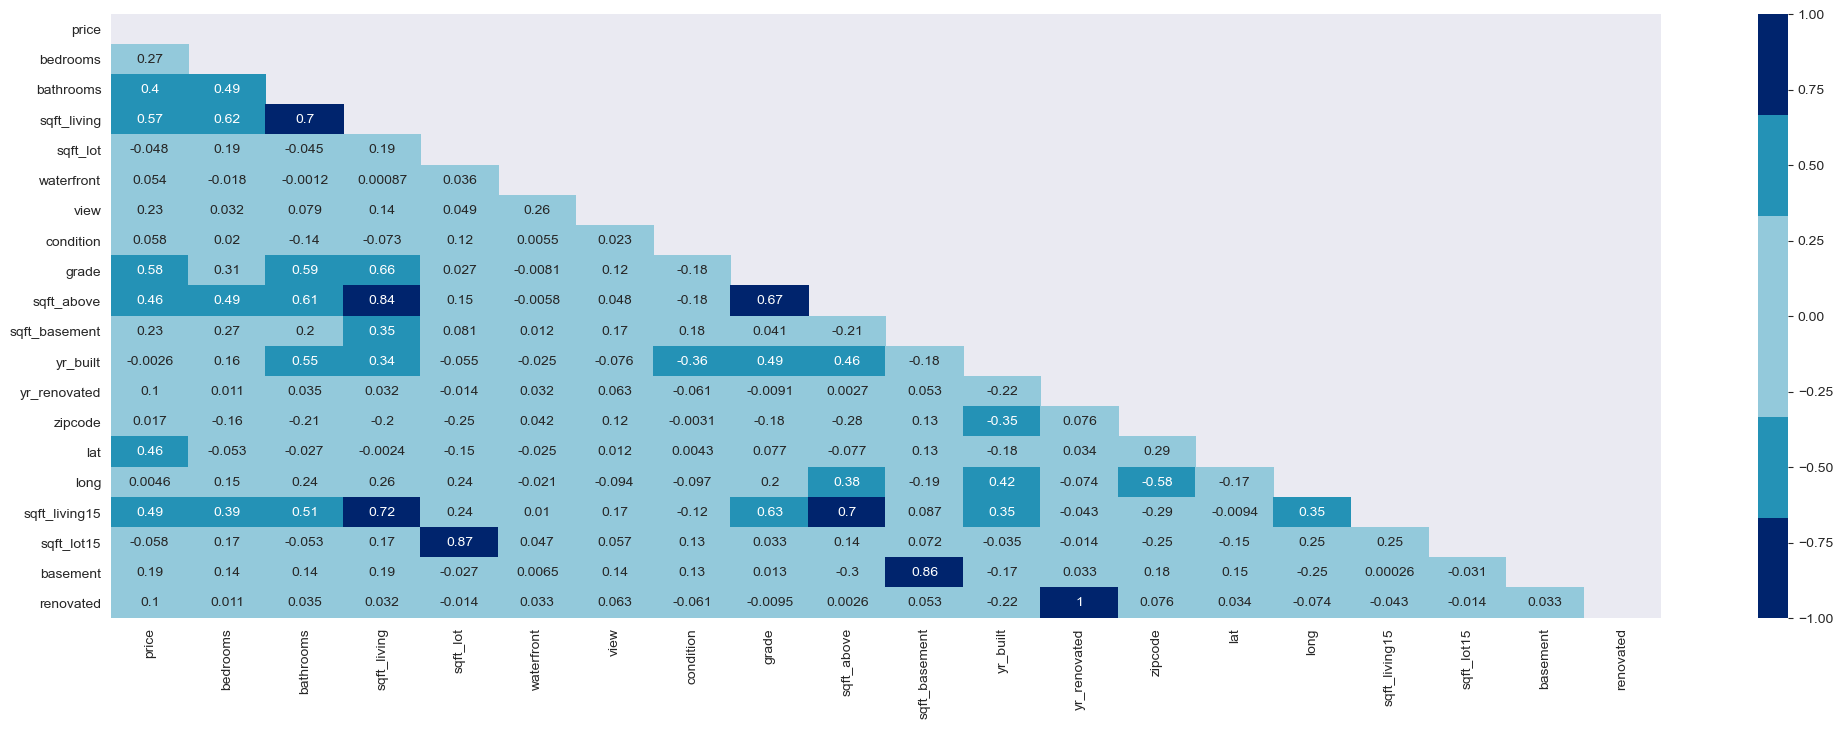

In [4]:
show_corr_matrix(df)

#### Observation 
---
    - Dark blue shaded are highly correlated (mostly square footage related data).
    - Light blue shaded are moderately correlated.
    - Sky Blue shaded have low to no correlation.

### Determining continuous and categorical data

In [5]:
continuous = {'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15'}
categoricals = set(df.columns) - continuous - {'price'}

### Checking Linearity of Square Footage Features with Price 

In [6]:
sqft_columns = df.filter(like='sqft').columns

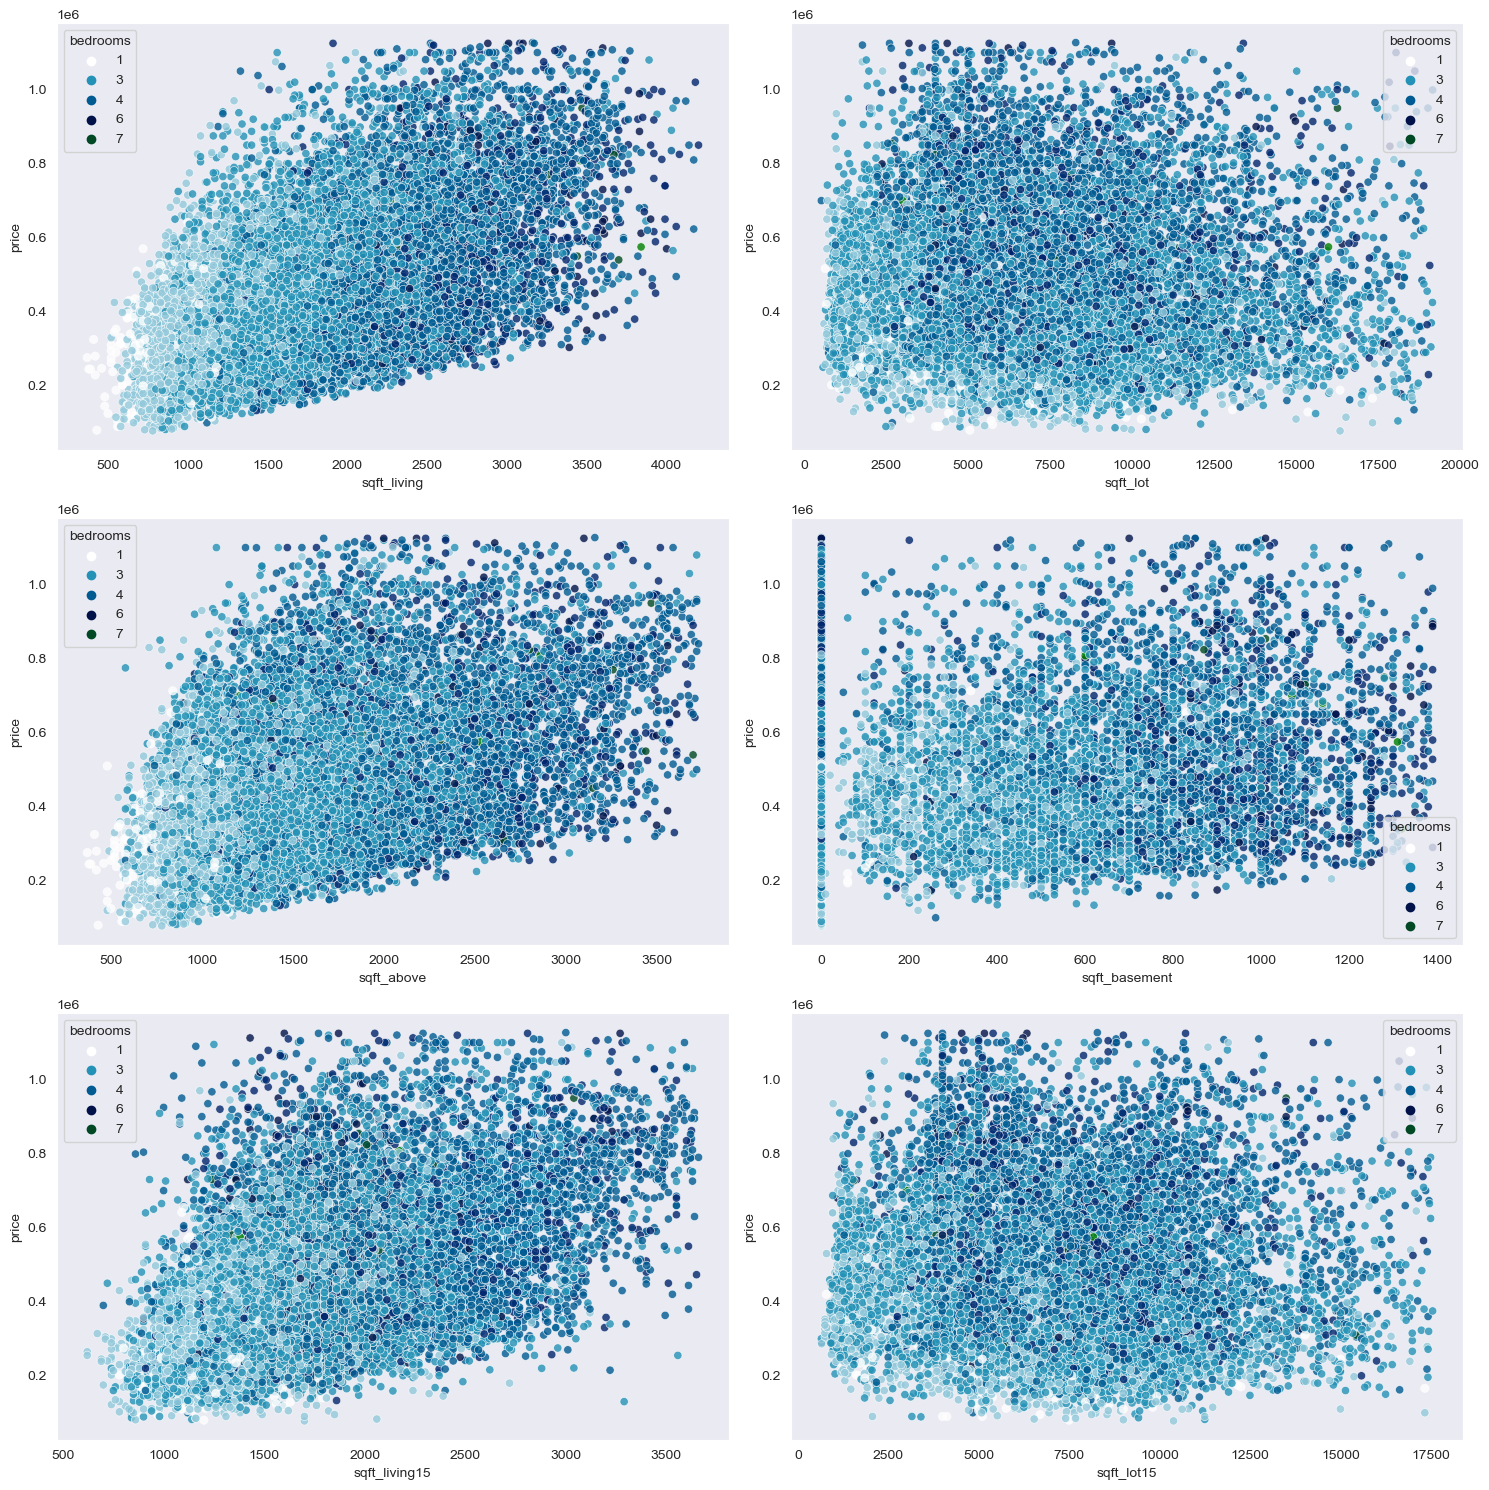

In [7]:
fig, axs = plt.subplots(nrows=3,ncols=2, figsize=(15,15), dpi=100)
axs = axs.flatten()
i = 0

for col in sqft_columns:
    sns.scatterplot(y='price', x=col, data=df, ax=axs[i], alpha=0.8, hue='bedrooms', palette='ocean_r')
    i += 1

plt.tight_layout()

#### Observations And Next steps
---
    - As we can see sqft_living15, sqft_living, sqft_above almost have the same variations with price.
    - sqft_living_15 is just the square footage of nearby house which does not add any value to our analysis and also it is correlated with sqft_living.
    - sqft_lot15 and sqft_lot does not have a linear realtionship and also high and low price are scatter all over which is not much helpful to gain any information.
    - But as sqft_lot is an imporatant feature to be considerd we won't drop it.

In [8]:
sqft_drop = ['sqft_lot15','sqft_living15']
df.drop(columns=sqft_drop, axis=1, inplace=True)
continuous = continuous - set(sqft_drop)

### Checking Linearity of Other continuous Features with Price

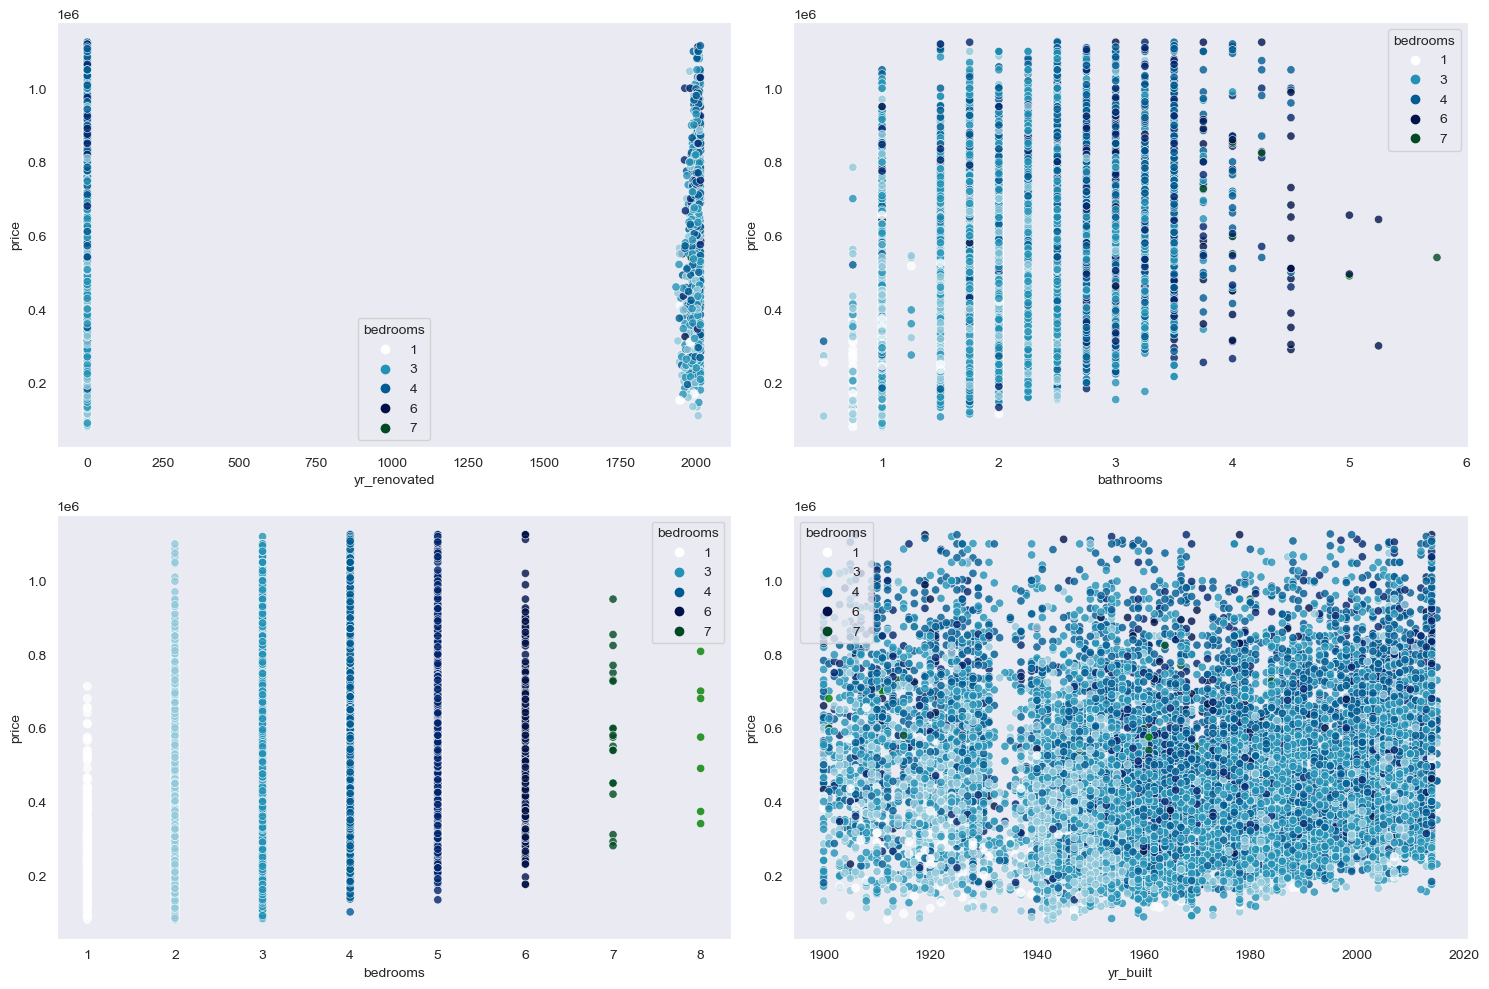

In [9]:
other_conti_cols = continuous - {'lat','long','sqft_living','sqft_above','sqft_lot','sqft_basement'}

fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(15,10), dpi=100)
axs = axs.flatten()
i = 0

for col in other_conti_cols:
    sns.scatterplot(y='price', x=col, data=df, ax=axs[i], alpha=0.8, hue='bedrooms', palette='ocean_r')
    i += 1

plt.tight_layout()

#### Observations And Next steps
---
    - Price does increase as number of bedroom and bathroom increases.
    - Year build has no effect on the price as those are scatter everwhere lets add a column age and see if it adds any value to the data.
    - As most of the house were never renovated beacuse of which we can treat it as categorical value where 0 is not renovated and 1 is renovated and drop yr_renovated.

In [10]:
df['age'] = df.yr_built.apply(lambda x : 2021-x)
continuous.add('age')

In [11]:
df.drop(columns=['yr_renovated','yr_built'], axis=1, inplace=True)
continuous = continuous - {'yr_renovated','yr_built'}

## Functions to run a model

In [12]:
def check_assumptions(result):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25,8),dpi=100)
    axes = axes.flatten()
    
    # Linearity
    actual_predict = pd.DataFrame(data=[result['y_predict'], result['y_test']], index=['predicted','actual']).T
    sns.regplot(x='actual', y='predicted', data=actual_predict, fit_reg=True, ax=axes[0])
    axes[0].set_title('Linearity')
    
    # Normality
    sns.distplot(x=result['residuals'], ax=axes[1])
    axes[1].set_title('Normality')
    
    #Homoscedasticity
    fig = plt.figure(figsize=(25,4),dpi=100)
    sns.scatterplot(x=result['y_predict'], y=result['residuals'], alpha=0.8)
    plt.axhline(0, ls='--')
    plt.title('Homoscedasticity')

def run_regression_model(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    
    y_predict = lr.predict(X_test)
    r_sqr_test = lr.score(X_test, y_test)
    r_sqr_train = lr.score(X_train, y_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_predict))
    rmse_train = np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))
    residuals = y_test - y_predict
    
    result = {'y_predict':y_predict, 'y_test':y_test, 'R2_train':r_sqr_train, 'R2_test':r_sqr_test, 'rmse_test':rmse_test, 'rmse_train':rmse_train, 'intercept':lr.intercept_, 'coef':lr.coef_, 'residuals':residuals}
    check_assumptions(result)
    return result

    
def run_ols(df, target, show_summary=True, split_ratio=0.2):
    
    features = df.drop(columns=[target], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(features, df[target], random_state=55, test_size=split_ratio)
    
    X = features
    y = df[target]

    model = sm.OLS(y, sm.add_constant(X)).fit()
    print(model)

    if show_summary:
        display(model.summary())
        
    result = run_regression_model(X_train, X_test, y_train, y_test)
    return result

def get_correlation(df):
    df=df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    # set index to pairs
    df.set_index(['pairs'], inplace = True)

    #drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column as cc rather than 0
    df.columns = ['cc']

    # drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    df.drop_duplicates(inplace=True)
    return df

### MODEL 1
_**Features added** - renovated, basement_

_**Features removed** - yr_renovated, yr_built, sqft_lot15, sqft_living15_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     2489.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:35:43   Log-Likelihood:            -2.2968e+05
No. Observations:               17611   AIC:                         4.594e+05
Df Residuals:                   17595   BIC:                         4.595e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.378e+06   1.76e+06      0.782      0.434   -2.07e+06    4.83e+06
bedrooms      -1.091e+04   1299.014     -8.396      0.000   -1.35e+04   -8359.977
bathrooms      1.936e+04   2078.132      9.316      0.000    1.53e+04    2.34e+04
sqft_living      60.5321      1.950     31.046      0.000      56.710      64.354
sqft_lot         -6.1520      0.278    -22.113      0.000      -6.697      -5.607
waterfront     1.961e+05   2.27e+04      8.625      0.000    1.52e+05    2.41e+05
view           3.706e+04   1604.810     23.091      0.000    3.39e+04    4.02e+04
condition      2.545e+04   1451.721     17.529      0.000    2.26e+04    2.83e+04
grade          8.213e+04   1387.580     59.190      0.000    7.94e+04    8.49e+04
sqft_above       60.6225      2.147     28.242      0.000      56.415      64.830
sqft_basement    -0.0906      3.219     -0.028      0.978      -6.400       6.219
zipcode        -294.5101     20.310    -14.501      0.000    -334.320    -254.701
lat            5.551e+05   6613.210     83.943      0.000    5.42e+05    5.68e+05
long          -4768.7211   8492.903     -0.561      0.574   -2.14e+04    1.19e+04
basement       3.204e+04   3559.856      8.999      0.000    2.51e+04     3.9e+04
renovated      2.416e+04   4838.275      4.993      0.000    1.47e+04    3.36e+04
age            1885.0488     44.153     42.694      0.000    1798.505    1971.593
==============================================================================
Omnibus:                     1791.794   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3551.342
Skew:                           0.668   Prob(JB):                         0.00
Kurtosis:                       4.748   Cond. No.                     4.15e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.91e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

{'y_predict': array([932974.9460193 , 246248.90523056, 630381.9476404 , ...,
        427562.36761291, 445114.42748688, 498319.47401453]),
 'y_test': 17282    623300
 9058     165000
 2975     660000
 8826     440000
 4681     540000
           ...  
 3613     295500
 12173    266000
 17607    400000
 14612    500000
 16484    390000
 Name: price, Length: 3523, dtype: int64,
 'R2_train': 0.6826802005097219,
 'R2_test': 0.6667337362779865,
 'rmse_test': 113480.52469776299,
 'rmse_train': 111173.52371147505,
 'intercept': 577552.6383726536,
 'coef': array([-1.15703794e+04,  1.93562064e+04,  6.13553088e+01, -5.96389546e+00,
         1.83544895e+05,  3.53497218e+04,  2.50191674e+04,  8.31915764e+04,
         6.05303853e+01,  8.24923544e-01, -2.93033159e+02,  5.53605094e+05,
        -1.06645580e+04,  3.05787867e+04,  3.30574212e+04,  1.90758569e+03]),
 'residuals': 17282   -309674.946019
 9058     -81248.905231
 2975      29618.052360
 8826       -463.485481
 4681      81325.796500
         

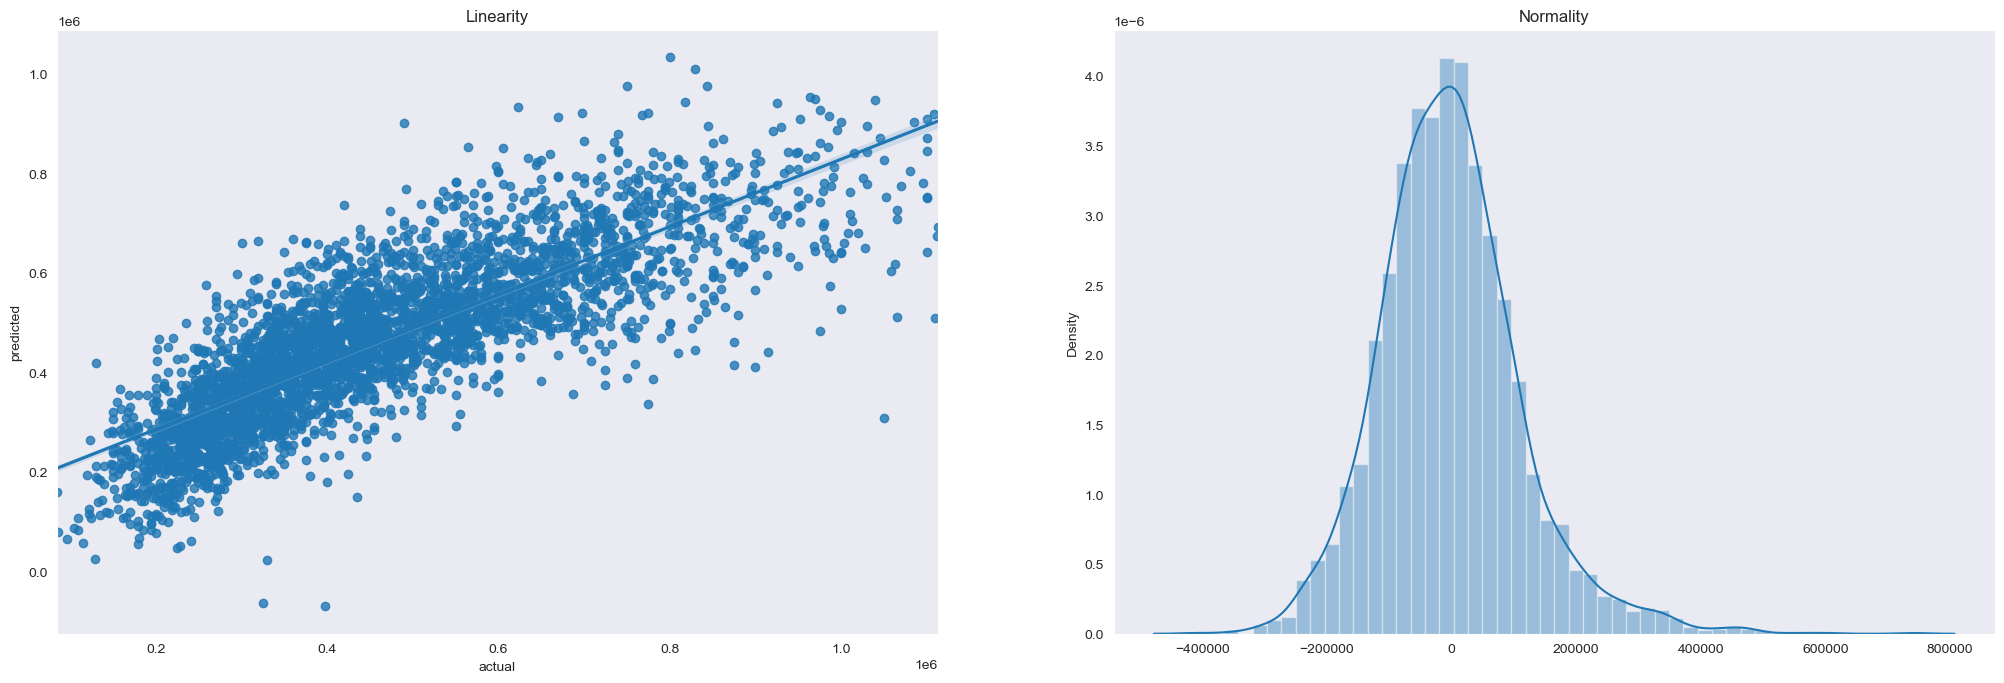

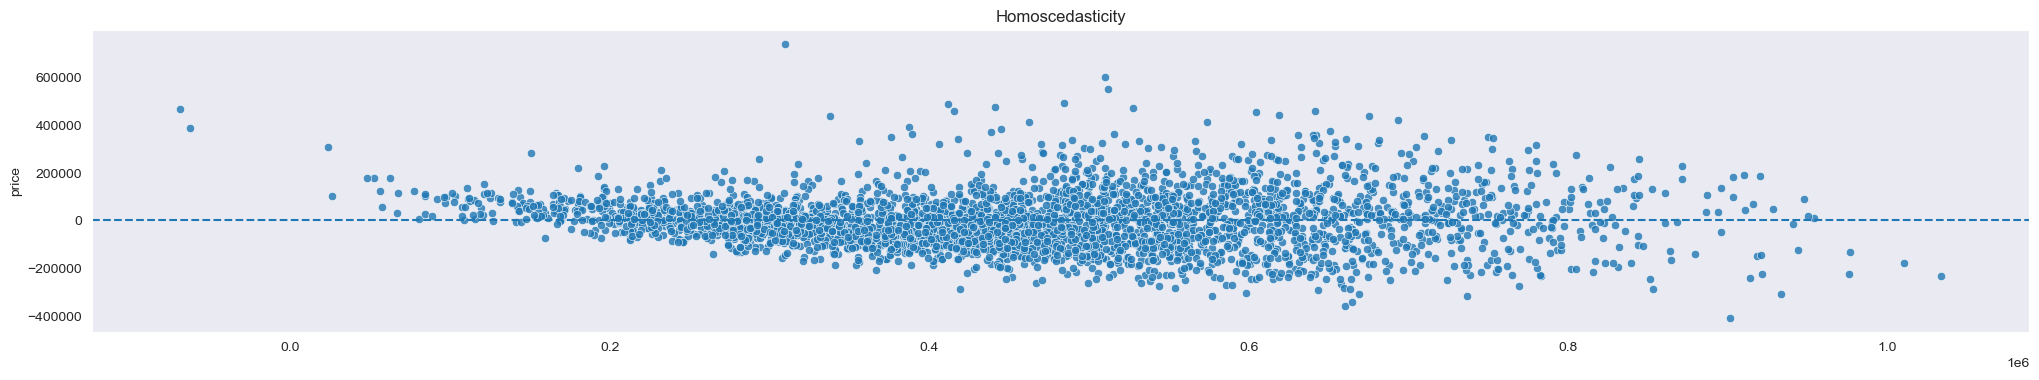

In [13]:
model1 = run_ols(df,'price')
model1

_**Lets check for hightly correlated pairs**_

In [14]:
corr = get_correlation(df.copy())
corr[(corr.cc>.75) & (corr.cc <1)]

cc
pairs                              
(basement, sqft_basement)  0.856243
(sqft_above, sqft_living)  0.841199

#### Observations And Next steps
---
    - As we know sqft_basement + sqft_above = sqft_living we can just use sqft_livng instead which is the total sqft of the house.
    - As per the above decision we will need to drop sqft_basement and sqft_above)

In [15]:
df2 = df.drop(columns=['sqft_basement','sqft_above'],axis=1)
continuous = continuous - {'sqft_basement','sqft_above'}

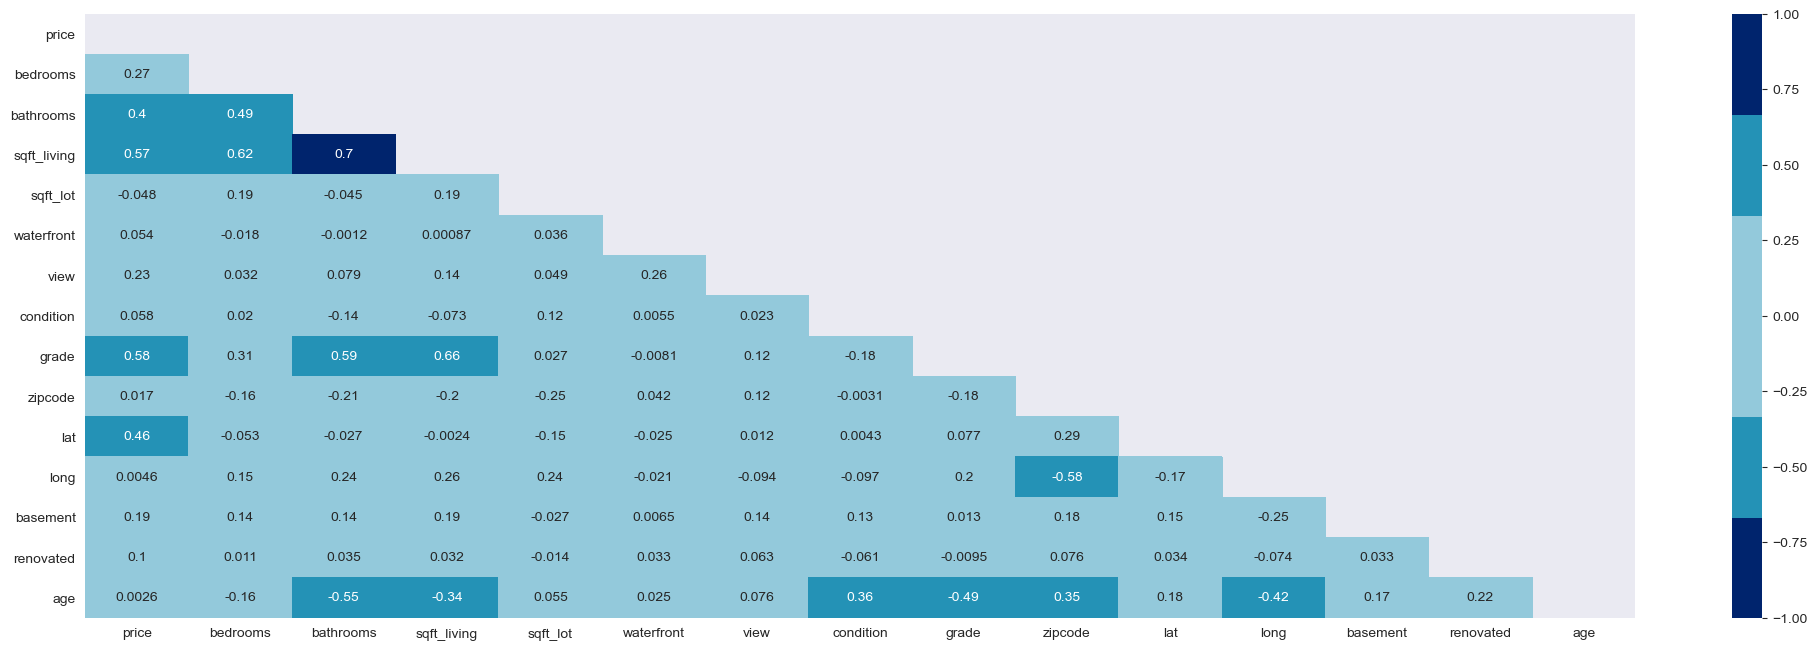

In [16]:
show_corr_matrix(df2)

#### Observations
---
    - Now we dont have any highly correlated pairs.

### Dealing with lat long features

_**Does Distance From Downdown affect house price ?**_

In [17]:
# King county's is in Seatlle city and it's lat long are 47.6050° N, 122.3344° W, lets calculate distance.

def haversine_distance(row):
    lat_p, lon_p = row['lat'], row['long']
    lat_d, lon_d = 47.6050, -122.3344
    radius = 6373 # km

    dlat = np.radians(lat_d - lat_p)
    dlon = np.radians(lon_d - lon_p)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat_p)) * np.cos(np.radians(lat_d)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = radius * c

    return round(distance,2)

df2['distance'] = df2.apply(haversine_distance, axis = 1)
continuous.add('distance')

<AxesSubplot:xlabel='distance', ylabel='price'>

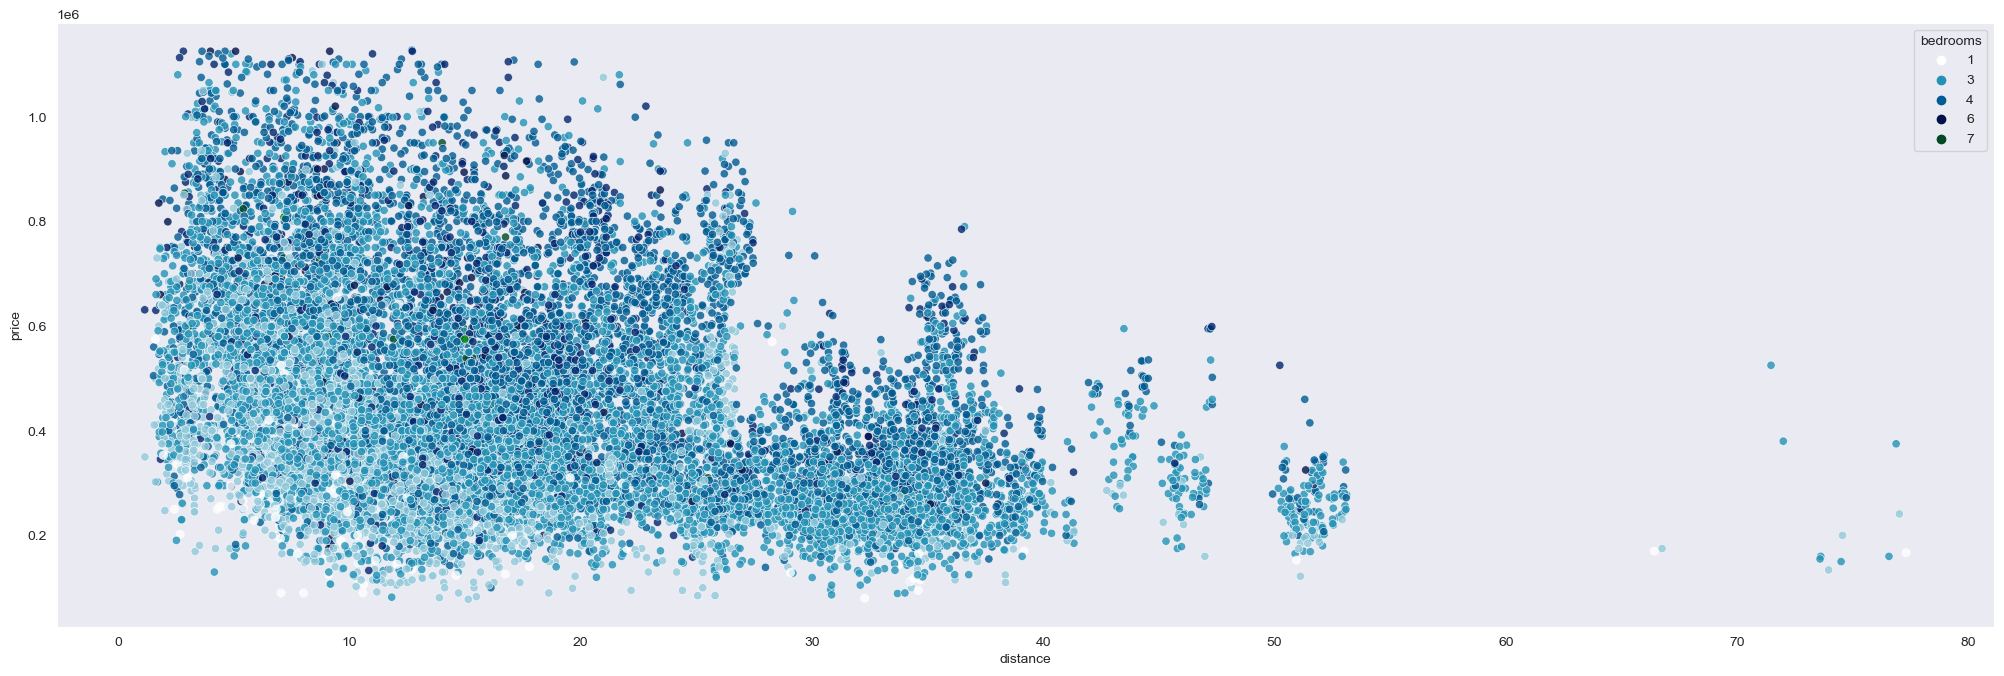

In [18]:
plt.figure(figsize=(25,8),dpi=100)
sns.scatterplot(y='price', x='distance', data=df2, alpha=0.8, hue='bedrooms', palette='ocean_r')

#### Observations
---
    - Not so perfect but a liitle chance of negative correlation can be seen as the distance increases from the downtown Seatlle the range of price starts getting narrow.

### MODEL 2
_**Features added** - distance_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     2980.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:35:46   Log-Likelihood:            -2.2857e+05
No. Observations:               17611   AIC:                         4.572e+05
Df Residuals:                   17595   BIC:                         4.573e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.683e+07   1.98e+06     28.681      0.000    5.29e+07    6.07e+07
bedrooms    -1.208e+04   1219.139     -9.912      0.000   -1.45e+04   -9694.018
bathrooms    1.629e+04   1952.391      8.345      0.000    1.25e+04    2.01e+04
sqft_living   115.0207      2.244     51.251      0.000     110.622     119.420
sqft_lot       -3.1102      0.269    -11.579      0.000      -3.637      -2.584
waterfront   2.025e+05   2.14e+04      9.484      0.000    1.61e+05    2.44e+05
view         3.549e+04   1504.795     23.582      0.000    3.25e+04    3.84e+04
condition    2.457e+04   1353.412     18.158      0.000    2.19e+04    2.72e+04
grade          7.6e+04   1289.240     58.952      0.000    7.35e+04    7.85e+04
zipcode      -431.2454     19.271    -22.378      0.000    -469.019    -393.472
lat          3.074e+05   7890.415     38.960      0.000    2.92e+05    3.23e+05
long         2.411e+05   9288.338     25.953      0.000    2.23e+05    2.59e+05
basement    -1.192e+04   1822.518     -6.541      0.000   -1.55e+04   -8348.996
renovated    2.997e+04   4544.653      6.595      0.000    2.11e+04    3.89e+04
age          1357.6636     42.580     31.885      0.000    1274.203    1441.124
distance    -7401.1070    147.468    -50.188      0.000   -7690.158   -7112.056
==============================================================================
Omnibus:                     1428.522   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2571.168
Skew:                           0.583   Prob(JB):                         0.00
Kurtosis:                       4.465   Cond. No.                     2.47e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

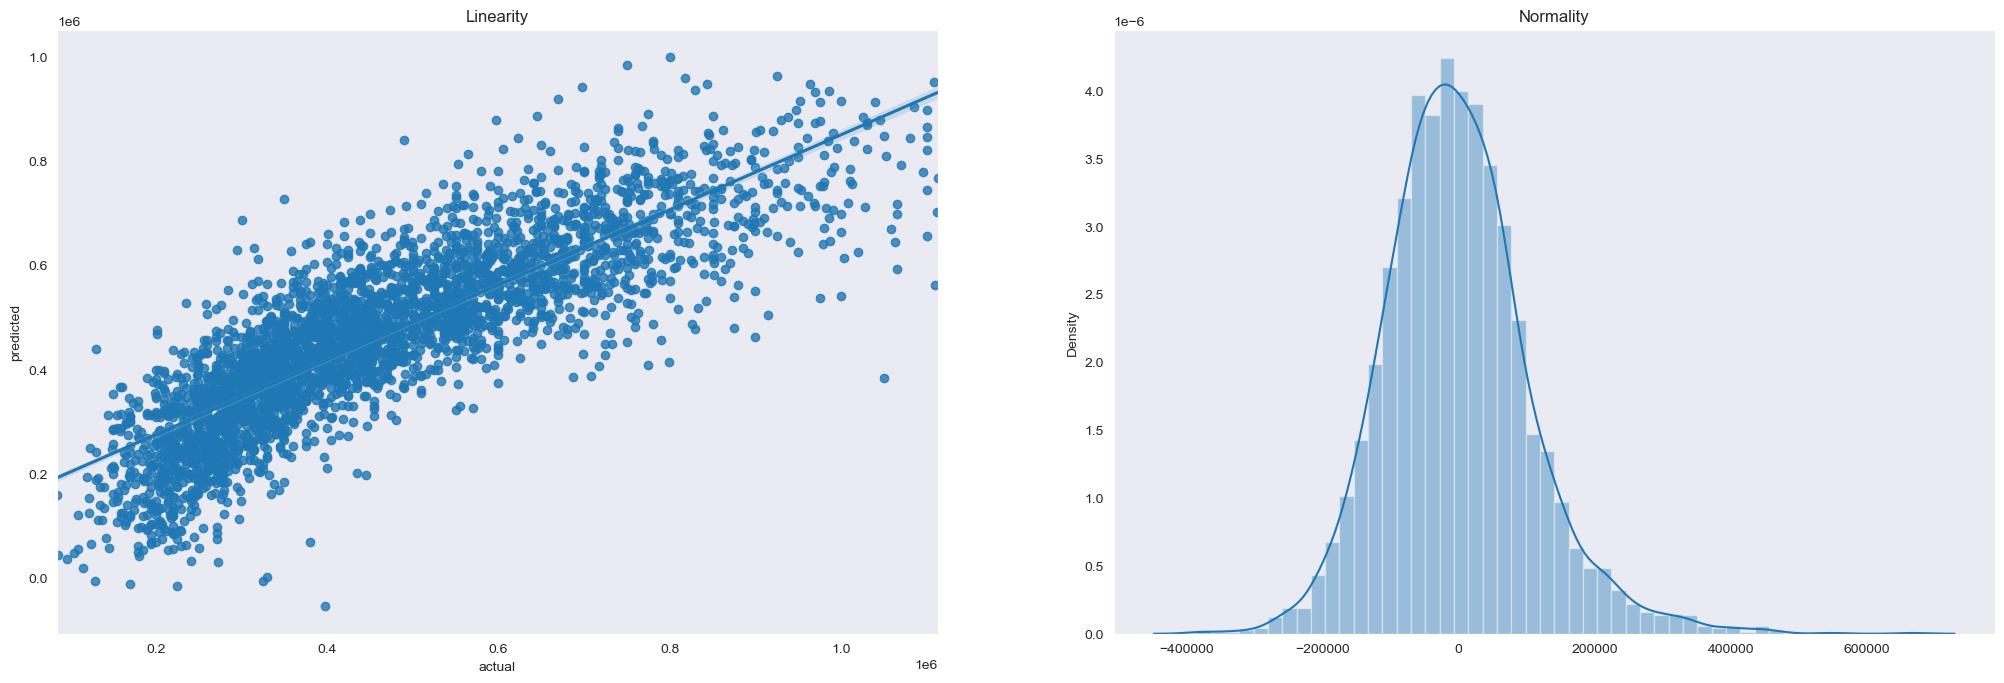

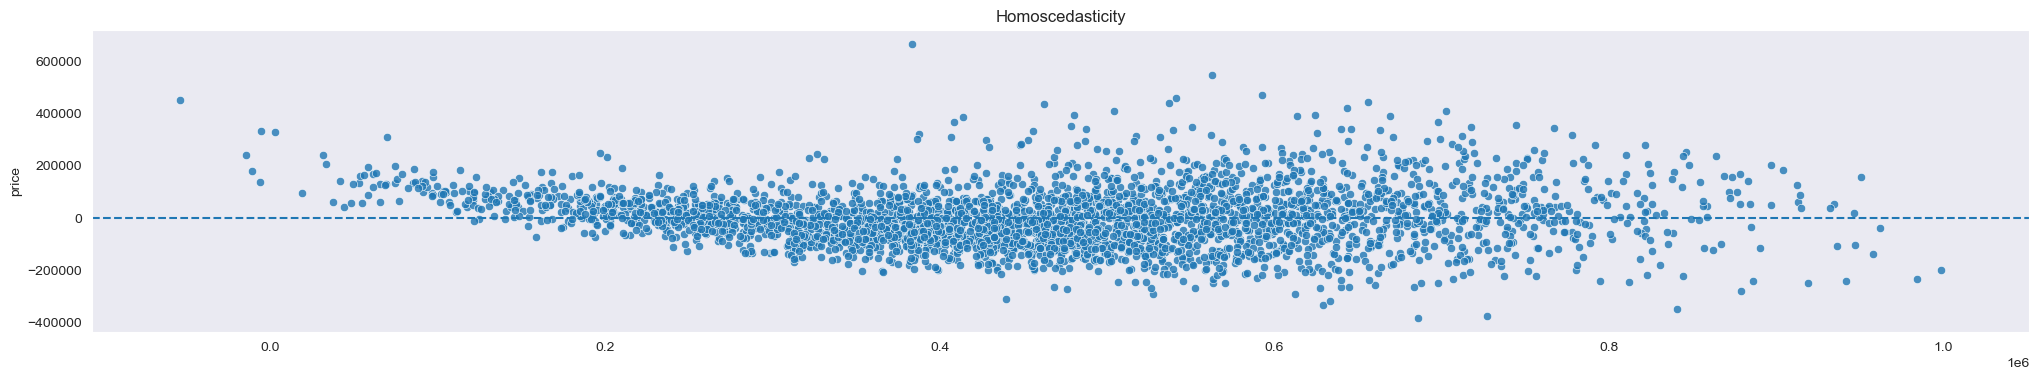

In [19]:
model2 = run_ols(df2,'price')

### Checking how given categorical Features affect with Price

_**Where are house prices is high? and where are they low?**_

<AxesSubplot:xlabel='long', ylabel='lat'>

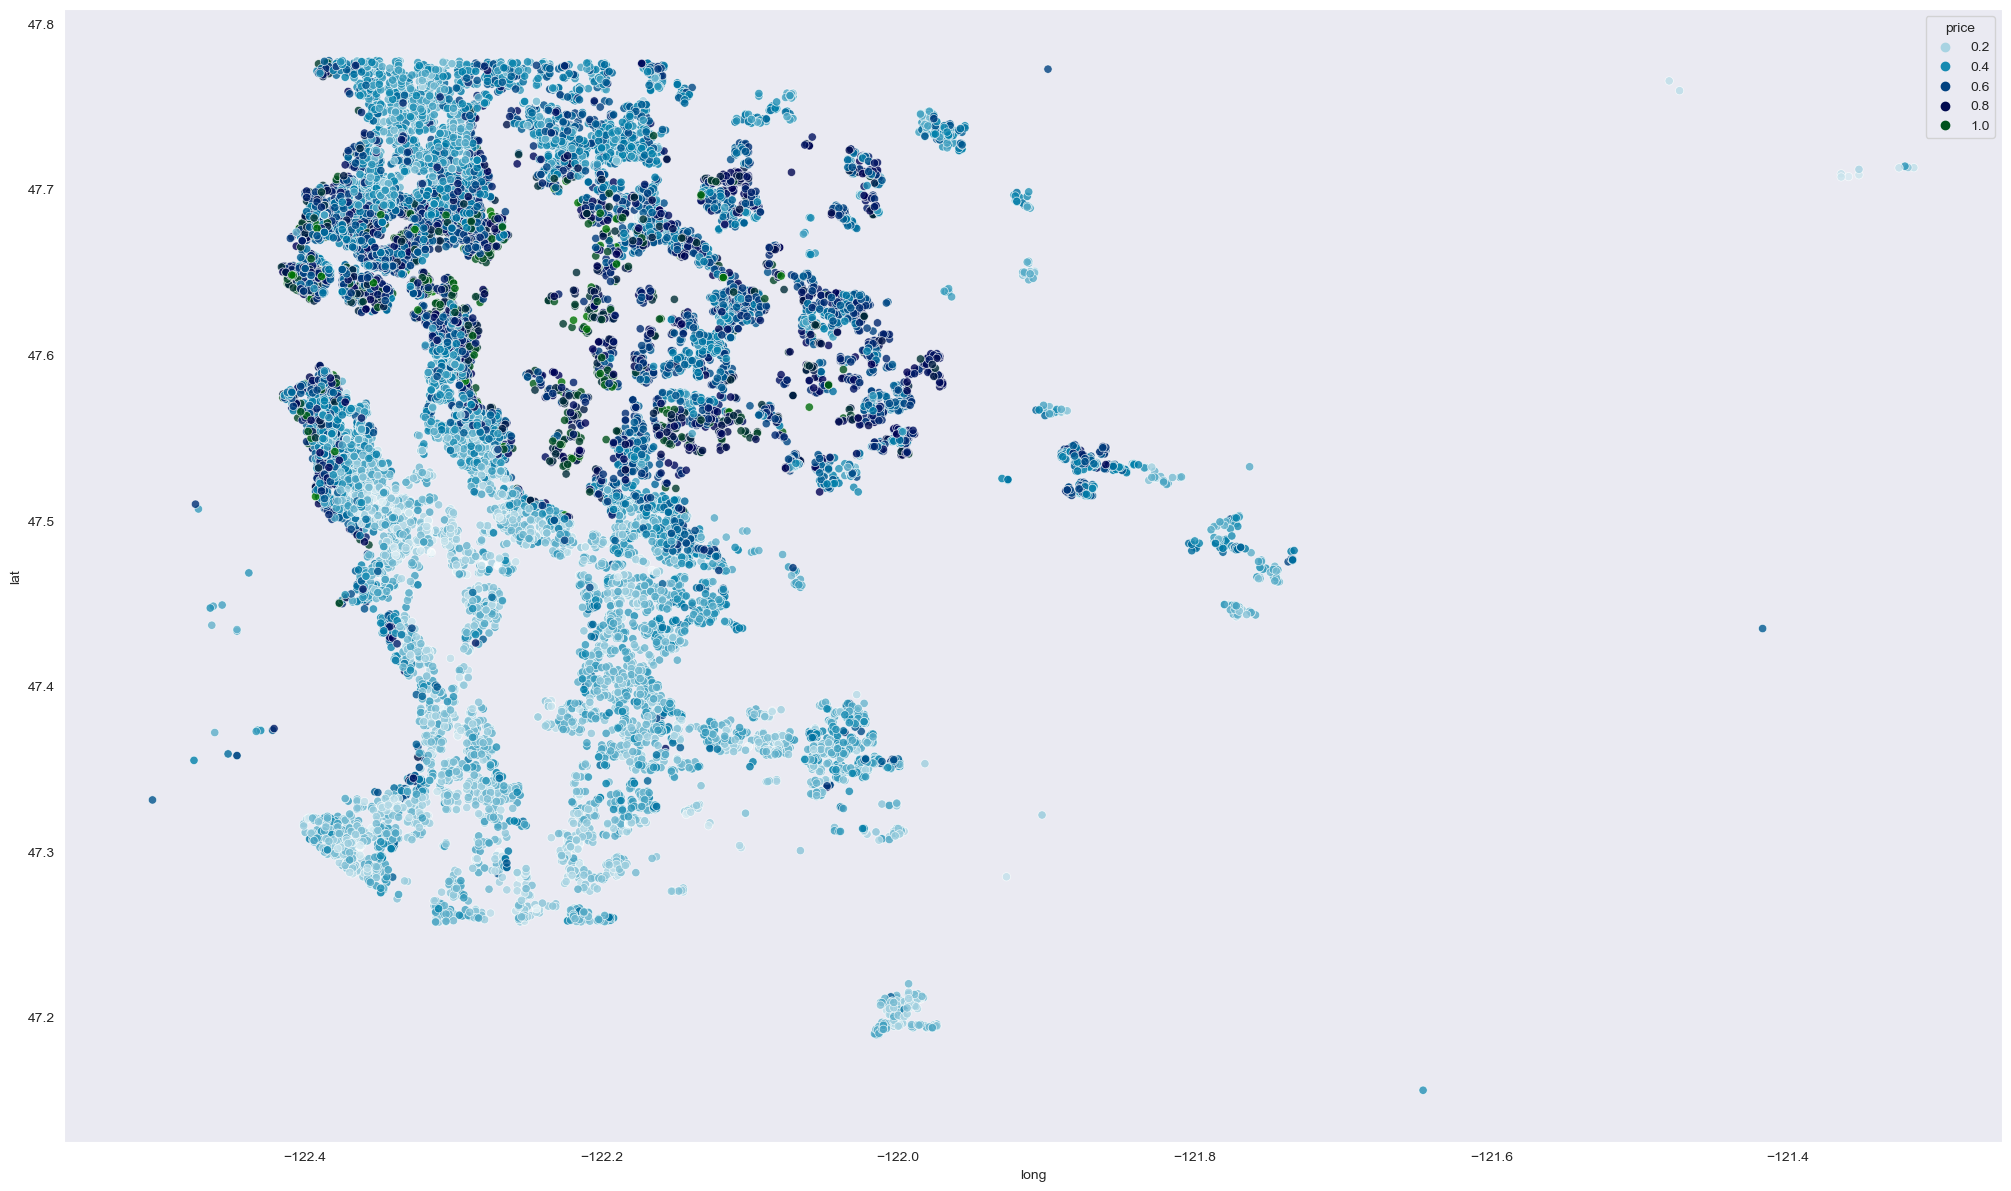

In [20]:
plt.figure(figsize=(25,15),dpi=100)
sns.scatterplot(y='lat', x='long', data=df2, alpha=0.8, hue='price', palette='ocean_r')

#### Observations
---
    - House price are high if the location is close to downtown seattle and if has a waterfront nearby.
    - Lower part of the king county has very low house price. 
    - Treating zipcodes as categorical variables might help getting best result for this.

_**Let see how 'condition', 'floors', 'grade', 'view', 'waterfront' are related to price**_

In [21]:
cat_cols = categoricals - {'zipcode','renovated','basement'}
cat_cols

{'condition', 'grade', 'view', 'waterfront'}

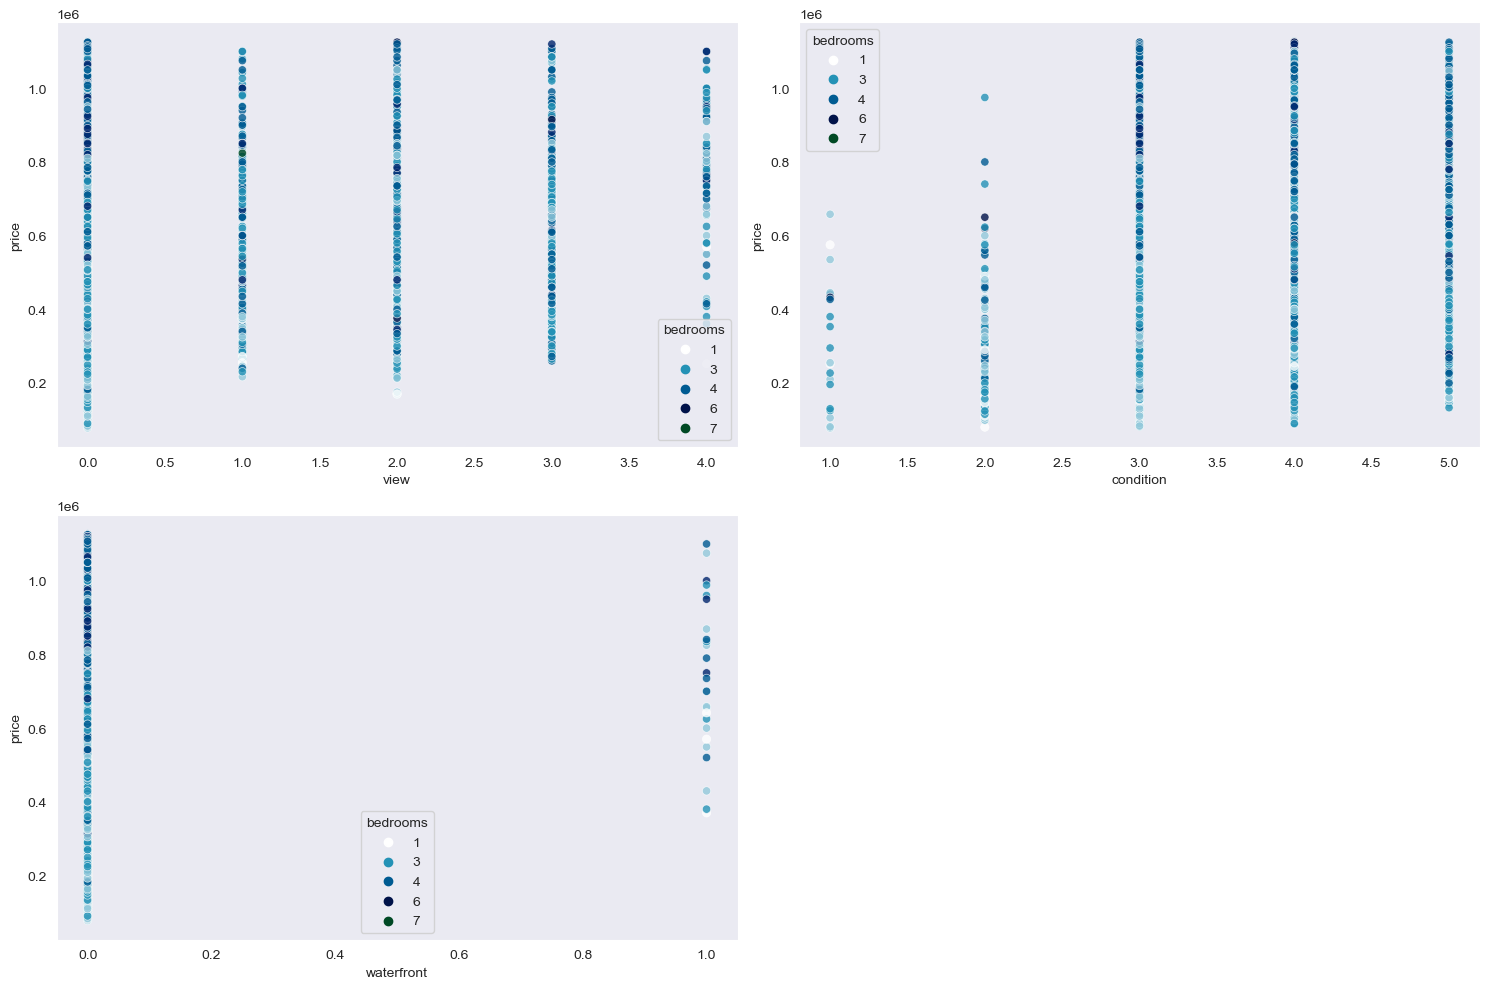

In [22]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(15,10), dpi=100)
axs = axs.flatten()
i = 0
fig.delaxes(axs[3])
for col in cat_cols:
    sns.scatterplot(y='price', x=col, data=df, ax=axs[i], alpha=0.8, hue='bedrooms', palette='ocean_r')
    i += 1

plt.tight_layout()

#### Observations
---
    - Having Waterfront and Good View from the house affects the price more.
    - Price starts to increase for house which has grade above 7.
    - Good Condition house have high price.

In [23]:
def plot_box(nrows, ncols, columns, df):
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, figsize=(15,10))
    axs = axs.flatten()
    i = 0
    
    # delete unused plots
    total_plots = len(axs)
    unused = len(axs) - len(columns)
    if unused > 0:
        for a in range(len(columns), total_plots):
            fig.delaxes(axs[a])
    
    
    for col in columns:
        sns.boxplot(y='price', x=col, data=df, ax=axs[i],palette=pal )
        i += 1

    plt.tight_layout()

In [24]:
cat = categoricals -{'renovated','basement','zipcode','waterfront'}

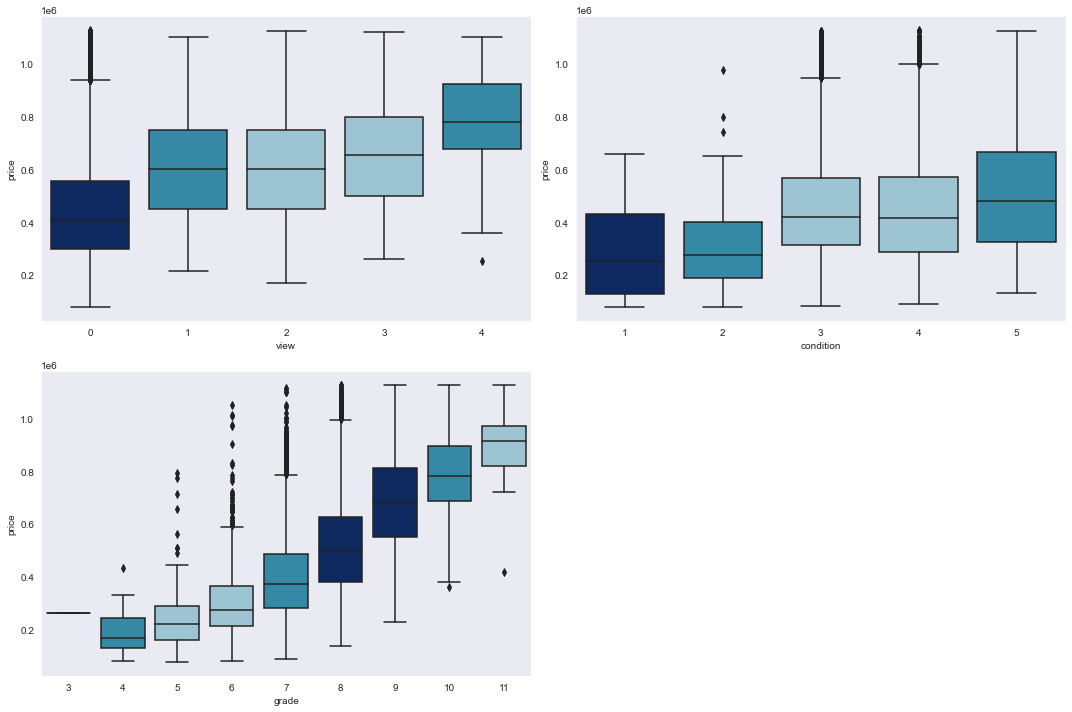

In [25]:
plot_box(2,2,cat, df2)

_**Lets do ANOVA test on categorical variables**_

In [26]:
def anova_test(df, col):
    formula = 'price~'+col
    lm_condition = ols(formula, df).fit()
    anova_condition = sm.stats.anova_lm(lm_condition, type=2)
    val = anova_condition["PR(>F)"][0]
    if val < 0.05:
        print(f"F-stat Probability: {val}. We reject the null hypothesis, and at least one of the sample populations is statistically different. Price is correlated with at least one of the {col} categories.")
    else:
        print("Do Not Reject Null Hypothesis")
        
    print("-------------------------------------------------------------------------------------------------------------------")

In [27]:
for col in categoricals:
    anova_test(df2, col)

F-stat Probability: 4.1422356854858833e-141. We reject the null hypothesis, and at least one of the sample populations is statistically different. Price is correlated with at least one of the basement categories.
-------------------------------------------------------------------------------------------------------------------
F-stat Probability: 0.0. We reject the null hypothesis, and at least one of the sample populations is statistically different. Price is correlated with at least one of the grade categories.
-------------------------------------------------------------------------------------------------------------------
F-stat Probability: 0.024417903302105318. We reject the null hypothesis, and at least one of the sample populations is statistically different. Price is correlated with at least one of the zipcode categories.
-------------------------------------------------------------------------------------------------------------------
F-stat Probability: 2.2594658323722995e-

#### Observations
---
    - All the categorical variable do have a little to more changes of affecting price. so we have to keep all the categorical variables. 

**Lets Create dummy variables**

In [28]:
condition_dummies = pd.get_dummies(df2['condition'], prefix = 'condition', drop_first= True)
grade_dummies = pd.get_dummies(df2['grade'], prefix = 'grade', drop_first= True)
view_dummies = pd.get_dummies(df2['view'], prefix = 'view', drop_first= True)
zip_dummies = pd.get_dummies(df2['zipcode'], prefix = 'zip', drop_first= True)

df3 = pd.concat([df2, condition_dummies, grade_dummies, view_dummies, zip_dummies], axis=1)
df3.drop(columns=['condition','grade','view','zipcode'], axis=1, inplace=True)
categoricals = categoricals - {'condition','grade','view','zipcode'}

### MODEL 3
_**Features added** - adding dummy variables_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     929.6
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:35:51   Log-Likelihood:            -2.2379e+05
No. Observations:               17611   AIC:                         4.478e+05
Df Residuals:                   17514   BIC:                         4.485e+05
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.487e+07   5.17e+06     10.621      0.000    4.47e+07     6.5e+07
bedrooms    -2582.3672    958.082     -2.695      0.007   -4460.303    -704.431
bathrooms    9371.8776   1522.031      6.157      0.000    6388.546    1.24e+04
sqft_living   117.3600      1.779     65.980      0.000     113.873     120.846
sqft_lot        2.2513      0.247      9.131      0.000       1.768       2.735
waterfront   1.886e+05   1.88e+04     10.008      0.000    1.52e+05    2.26e+05
lat         -1.994e+05   4.02e+04     -4.963      0.000   -2.78e+05   -1.21e+05
long         3.699e+05   3.75e+04      9.868      0.000    2.96e+05    4.43e+05
basement     -1.63e+04   1449.265    -11.249      0.000   -1.91e+04   -1.35e+04
renovated    3.075e+04   3509.846      8.761      0.000    2.39e+04    3.76e+04
age           455.8147     35.938     12.683      0.000     385.372     526.257
distance    -7777.3863    414.324    -18.771      0.000   -8589.503   -6965.270
condition_2  8.853e+04    1.9e+04      4.660      0.000    5.13e+04    1.26e+05
condition_3  1.184e+05   1.77e+04      6.680      0.000    8.36e+04    1.53e+05
condition_4  1.361e+05   1.77e+04      7.675      0.000    1.01e+05    1.71e+05
condition_5  1.679e+05   1.78e+04      9.424      0.000    1.33e+05    2.03e+05
grade_4     -1.241e+05   8.26e+04     -1.502      0.133   -2.86e+05    3.79e+04
grade_5     -1.268e+05   8.06e+04     -1.573      0.116   -2.85e+05    3.12e+04
grade_6     -1.137e+05   8.04e+04     -1.413      0.158   -2.71e+05     4.4e+04
grade_7     -8.551e+04   8.04e+04     -1.063      0.288   -2.43e+05    7.21e+04
grade_8     -4.152e+04   8.05e+04     -0.516      0.606   -1.99e+05    1.16e+05
grade_9      3.756e+04   8.05e+04      0.467      0.641    -1.2e+05    1.95e+05
grade_10     7.728e+04   8.06e+04      0.959      0.338   -8.07e+04    2.35e+05
grade_11     1.512e+05    8.2e+04      1.844      0.065   -9539.508    3.12e+05
view_1       6.035e+04   5420.595     11.133      0.000    4.97e+04     7.1e+04
view_2       6.125e+04   3407.367     17.977      0.000    5.46e+04    6.79e+04
view_3       9.382e+04   5505.143     17.042      0.000     8.3e+04    1.05e+05
view_4       1.807e+05   1.08e+04     16.794      0.000     1.6e+05    2.02e+05
zip_98002   -7382.2193   7674.295     -0.962      0.336   -2.24e+04    7660.163
zip_98003    1.299e+04   7018.384      1.851      0.064    -764.890    2.67e+04
zip_98004    3.801e+05   1.66e+04     22.846      0.000    3.47e+05    4.13e+05
zip_98005    1.963e+05    1.7e+04     11.516      0.000    1.63e+05     2.3e+05
zip_98006    1.364e+05   1.46e+04      9.325      0.000    1.08e+05    1.65e+05
zip_98007    1.214e+05   1.69e+04      7.193      0.000    8.83e+04    1.55e+05
zip_98008    1.153e+05   1.64e+04      7.039      0.000    8.32e+04    1.47e+05
zip_98010    4.177e+04   1.51e+04      2.76

{'y_predict': array([766588.665866  , 182955.51387622, 673989.67679879, ...,
        431467.61833654, 477408.39729008, 424743.29855333]),
 'y_test': 17282    623300
 9058     165000
 2975     660000
 8826     440000
 4681     540000
           ...  
 3613     295500
 12173    266000
 17607    400000
 14612    500000
 16484    390000
 Name: price, Length: 3523, dtype: int64,
 'R2_train': 0.8388811807268561,
 'R2_test': 0.8224741352238167,
 'rmse_test': 82824.05269476563,
 'rmse_train': 79218.3734105245,
 'intercept': 51173546.407396466,
 'coef': array([-3.43297212e+03,  9.46177689e+03,  1.19212278e+02,  2.22751325e+00,
         1.75837577e+05, -2.01575849e+05,  3.38800581e+05, -1.78213381e+04,
         3.58637925e+04,  4.64022524e+02, -7.67887924e+03,  7.19852751e+04,
         1.08946410e+05,  1.26936873e+05,  1.58725458e+05, -1.31848789e+05,
        -1.24253085e+05, -1.13795548e+05, -8.51786309e+04, -4.13939206e+04,
         3.81530616e+04,  7.48337543e+04,  1.81995279e+05,  5.81671642

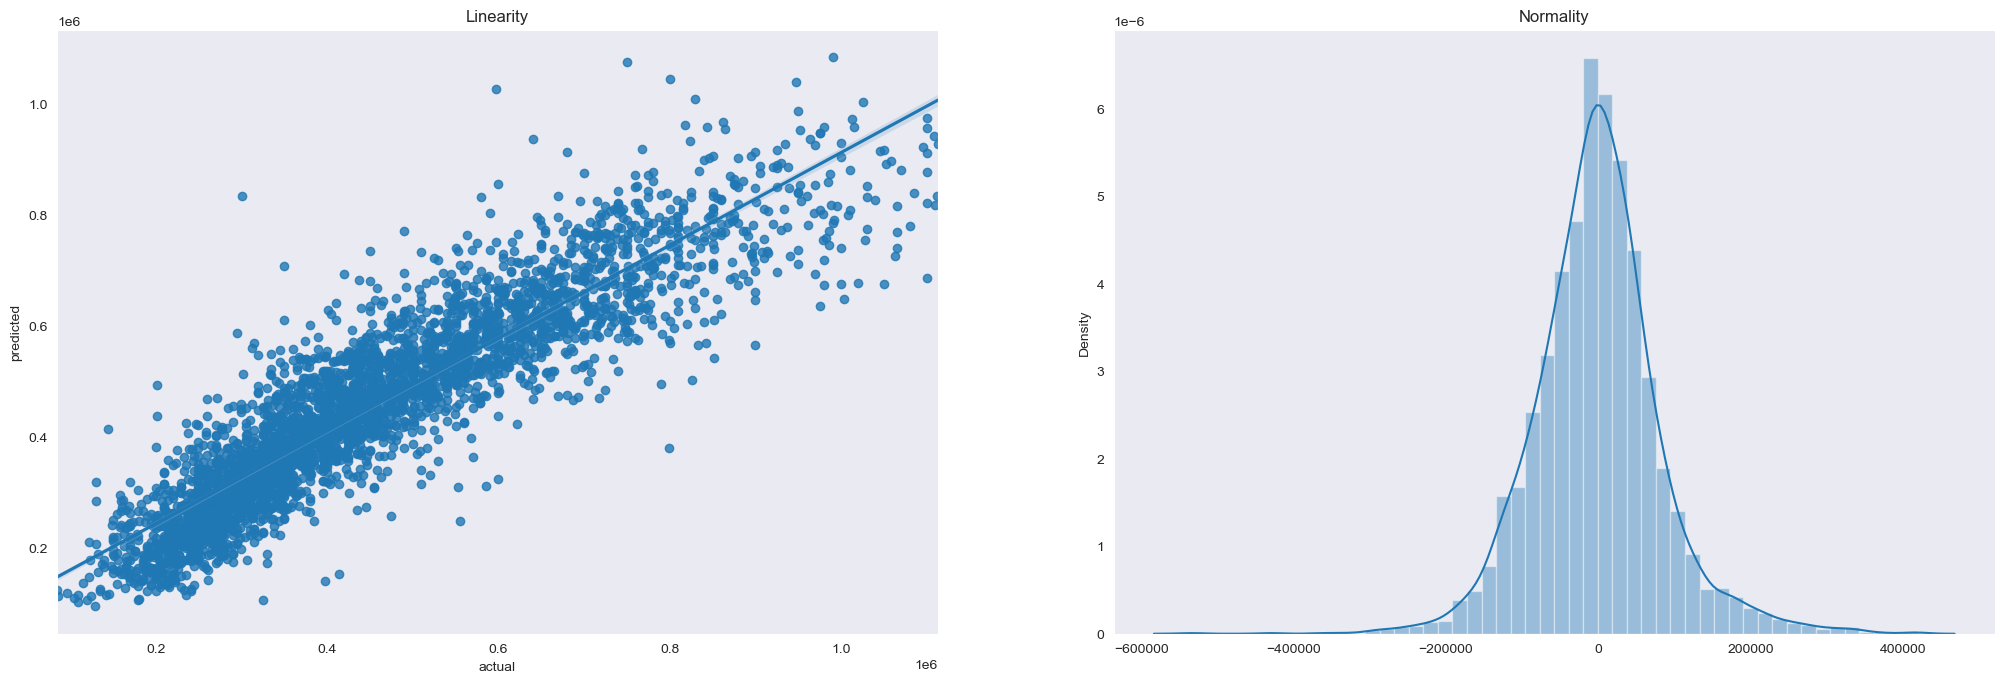

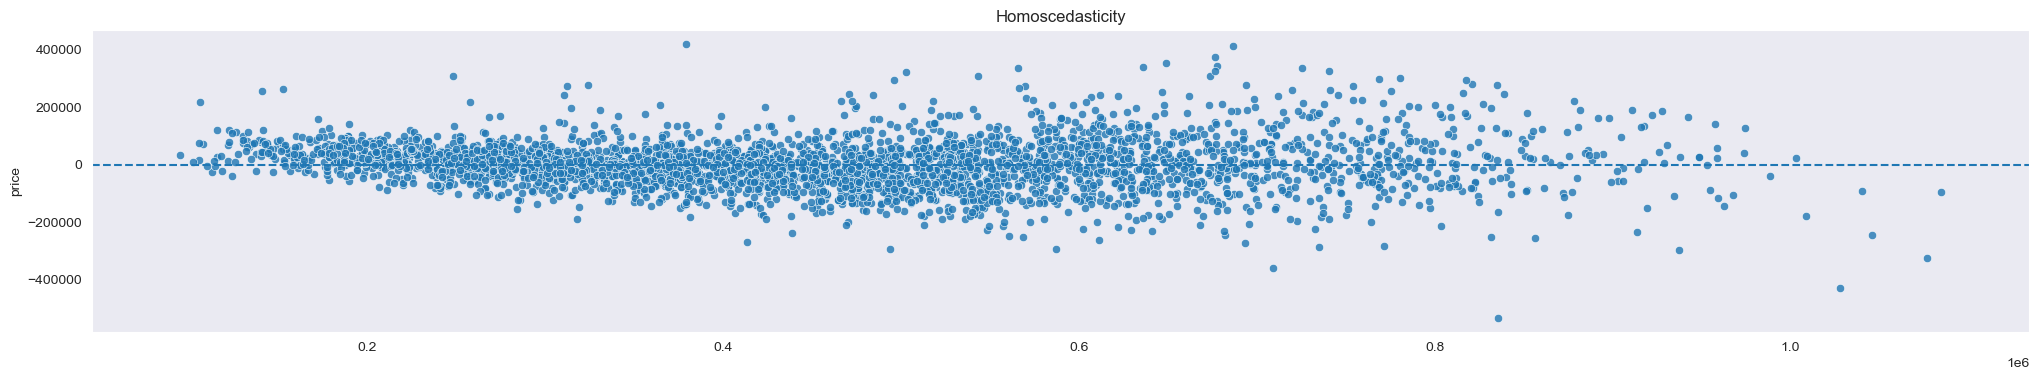

In [29]:
model3 = run_ols(df3,'price')
model3

### Transforming Target Variable

In [30]:
df4 = df3.copy()

In [31]:
continuous

{'age',
 'bathrooms',
 'bedrooms',
 'distance',
 'lat',
 'long',
 'sqft_living',
 'sqft_lot'}

In [32]:
df4['price'] = df4.price.apply(np.log)

### MODEL 4 (FINAL MODEL)
_**Target modified** - log transformed price_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     1001.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:35:52   Log-Likelihood:                 6100.4
No. Observations:               17611   AIC:                        -1.201e+04
Df Residuals:                   17514   BIC:                        -1.125e+04
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          89.4151     11.067      8.079      0.000      67.722     111.108
bedrooms       -0.0061      0.002     -2.984      0.003      -0.010      -0.002
bathrooms       0.0284      0.003      8.711      0.000       0.022       0.035
sqft_living     0.0003   3.81e-06     65.818      0.000       0.000       0.000
sqft_lot     5.628e-06   5.28e-07     10.655      0.000    4.59e-06    6.66e-06
waterfront      0.4707      0.040     11.656      0.000       0.392       0.550
lat            -0.1286      0.086     -1.494      0.135      -0.297       0.040
long            0.5811      0.080      7.236      0.000       0.424       0.739
basement       -0.0307      0.003     -9.881      0.000      -0.037      -0.025
renovated       0.0423      0.008      5.628      0.000       0.028       0.057
age             0.0007    7.7e-05      9.688      0.000       0.001       0.001
distance       -0.0170      0.001    -19.107      0.000      -0.019      -0.015
condition_2     0.2165      0.041      5.320      0.000       0.137       0.296
condition_3     0.3439      0.038      9.058      0.000       0.270       0.418
condition_4     0.3826      0.038     10.072      0.000       0.308       0.457
condition_5     0.4370      0.038     11.447      0.000       0.362       0.512
grade_4        -0.5764      0.177     -3.256      0.001      -0.923      -0.229
grade_5        -0.4719      0.173     -2.732      0.006      -0.810      -0.133
grade_6        -0.3354      0.172     -1.946      0.052      -0.673       0.002
grade_7        -0.2165      0.172     -1.256      0.209      -0.554       0.121
grade_8        -0.1187      0.172     -0.689      0.491      -0.457       0.219
grade_9        -0.0146      0.173     -0.085      0.933      -0.353       0.324
grade_10        0.0115      0.173      0.067      0.947      -0.327       0.350
grade_11        0.0550      0.176      0.313      0.754      -0.289       0.399
view_1          0.1174      0.012     10.113      0.000       0.095       0.140
view_2          0.1128      0.007     15.450      0.000       0.098       0.127
view_3          0.1712      0.012     14.513      0.000       0.148       0.194
view_4          0.2780      0.023     12.059      0.000       0.233       0.323
zip_98002      -0.0302      0.016     -1.837      0.066      -0.062       0.002
zip_98003       0.0347      0.015      2.308      0.021       0.005       0.064
zip_98004       0.6904      0.036     19.369      0.000       0.621       0.760
zip_98005       0.4137      0.037     11.326      0.000       0.342       0.485
zip_98006       0.3150      0.031     10.054      0.000       0.254       0.376
zip_98007       0.3101      0.036      8.574      0.000       0.239       0.381
zip_98008       0.3184      0.035      9.075      0.000       0.250       0.387
zip_98010       0.2001      0.032      6.17

{'y_predict': array([13.64767321, 12.27801923, 13.43627694, ..., 12.87225354,
        12.96873219, 12.83212815]),
 'y_test': 17282    13.342783
 9058     12.013701
 2975     13.399995
 8826     12.994530
 4681     13.199324
            ...    
 3613     12.596424
 12173    12.491252
 17607    12.899220
 14612    13.122363
 16484    12.873902
 Name: price, Length: 3523, dtype: float64,
 'R2_train': 0.8473515599965338,
 'R2_test': 0.8379689539838605,
 'rmse_test': 0.17473536305784634,
 'rmse_train': 0.17045905068521264,
 'intercept': 79.65819164529479,
 'coef': array([-7.85182471e-03,  2.84252282e-02,  2.53989498e-04,  5.55555606e-06,
         4.36377975e-01, -1.34701896e-01,  4.98959820e-01, -3.31903335e-02,
         5.00410754e-02,  7.62334371e-04, -1.65818097e-02,  1.73318418e-01,
         3.31554018e-01,  3.69997184e-01,  4.25022827e-01, -6.71767197e-01,
        -4.67843716e-01, -3.35572508e-01, -2.15039370e-01, -1.18811015e-01,
        -1.36576894e-02,  8.13034050e-03,  8.54571113e-

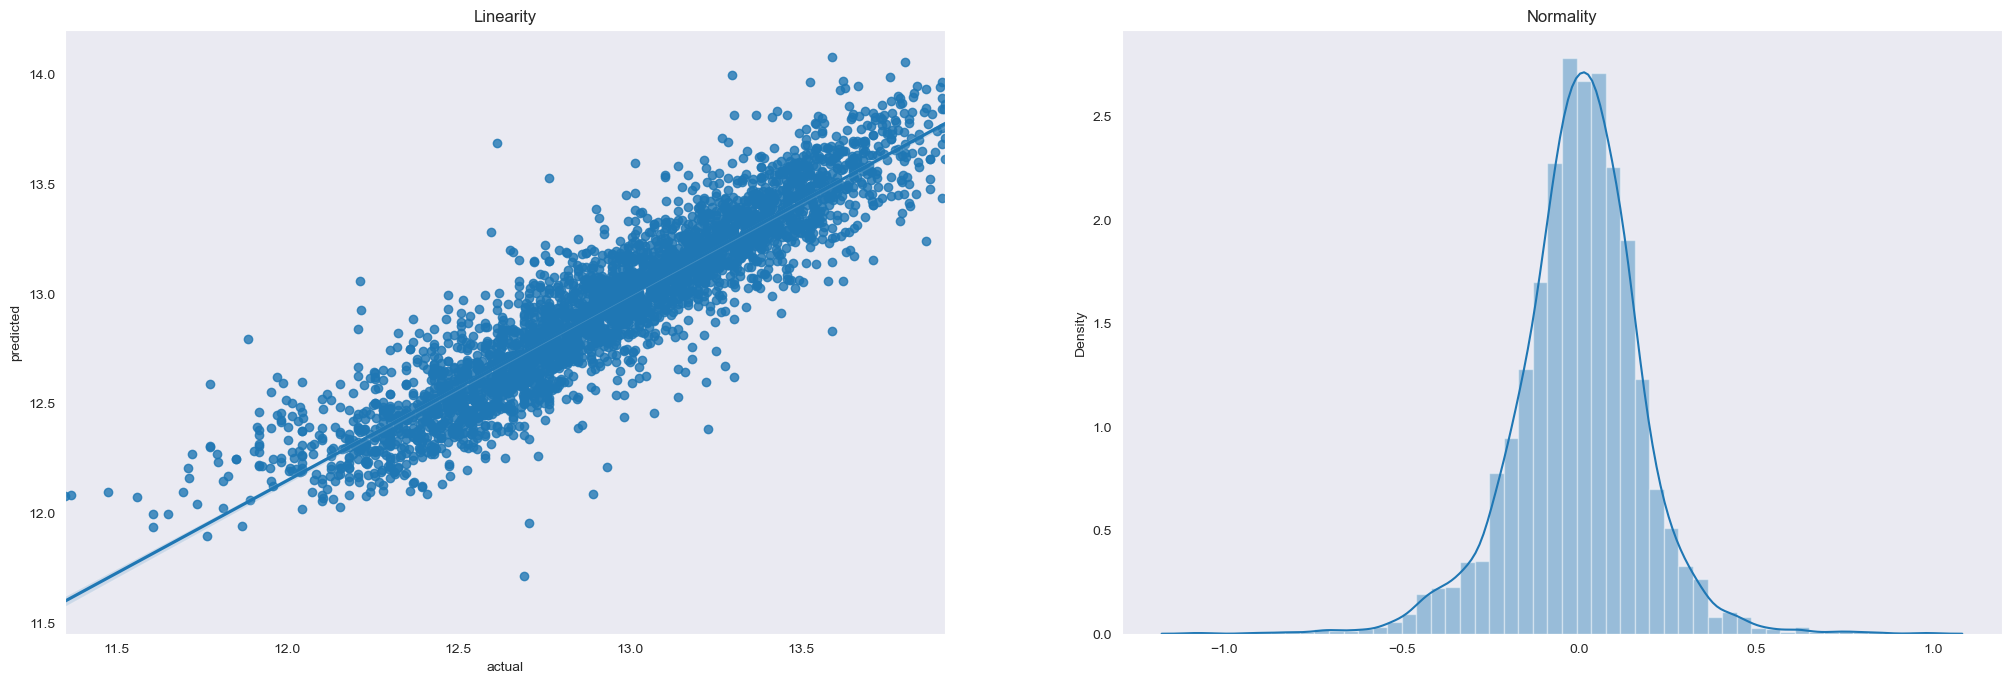

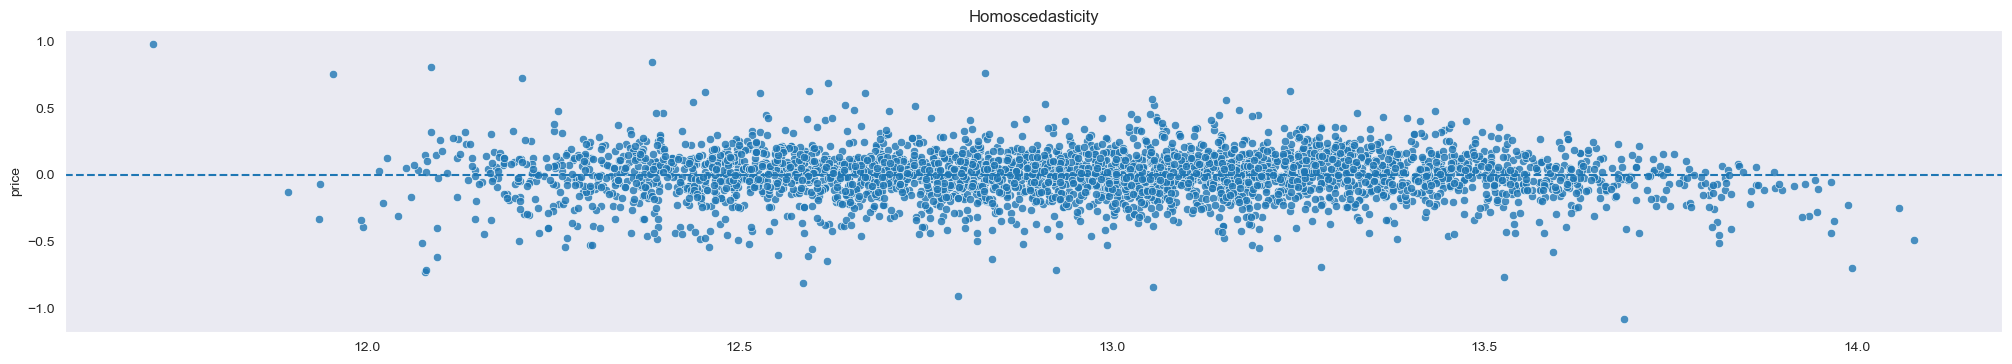

In [33]:
model4 = run_ols(df4,'price')
model4

#### Observations
---
    - All the assumption improved after doing the log transform on target variable.

In [34]:
p_value = shapiro(model4['residuals'])
print(p_value)
if p_value[1] < 0.05:
    print('Null hypothesis Rejected')
else:
    print('Faild to reject null hypothesis')

ShapiroResult(statistic=0.9729882478713989, pvalue=2.7199159803018554e-25)
Null hypothesis Rejected


### Model Validation

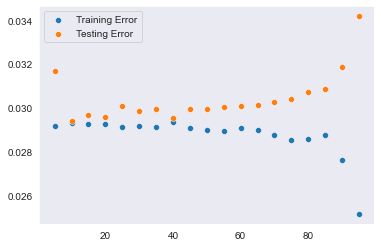

In [35]:
X = df4.drop(columns=['price'],axis=1)
y = df4.price
linreg = LinearRegression()

train_err = []
test_err = []
t_sizes = range(5,100,5)
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))

sns.scatterplot(t_sizes, train_err, label='Training Error')
sns.scatterplot(t_sizes, test_err, label='Testing Error')
plt.legend()

### Cross Validate

In [36]:
def cross_validate(X, y, k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    linreg = LinearRegression()
    mse = make_scorer(mean_squared_error)
    cvs = cross_val_score(linreg, X_train, y_train, cv=k,  scoring=mse)
    return cvs

In [37]:
features = df4.drop(columns=['price'], axis=1)
target = df4['price']
score = cross_validate(features, target, 5)
mean_corss_vallidate_score = score.mean()
print(f"Mean RMSE : {np.sqrt(mean_corss_vallidate_score)}")
print(f"Final Model TEST RMSE: {model4['rmse_test']}")

Mean RMSE : 0.1722421539804627
Final Model TEST RMSE: 0.17473536305784634


### Coefficients

In [38]:
model_cols = df4.columns.to_list()[1:]
model_coef = model4['coef']

features_coef = dict(zip(model_cols,model_coef))
features_coef = pd.DataFrame([features_coef])

In [39]:
zip_coef = features_coef.filter(like='zip_').T
zip_coef.rename({0: 'coef'}, axis=1, inplace=True)
zip_top = zip_coef.sort_values(by=['coef'], axis=0, ascending=False)[:10]
zip_top

coef
zip_98039  0.923498
zip_98004  0.695160
zip_98119  0.565336
zip_98105  0.539137
zip_98109  0.529522
zip_98040  0.528327
zip_98112  0.526959
zip_98199  0.525581
zip_98107  0.512137
zip_98117  0.511832

**TOP 10 Zipcodes that has hight impact on the price.**

In [40]:
grade_coef = features_coef.filter(like='grade_').T
grade_coef.rename({0: 'coef'}, axis=1, inplace=True)
grade_top = grade_coef.sort_values(by=['coef'], axis=0, ascending=False)
grade_top

coef
grade_11  0.085457
grade_10  0.008130
grade_9  -0.013658
grade_8  -0.118811
grade_7  -0.215039
grade_6  -0.335573
grade_5  -0.467844
grade_4  -0.671767

**As the grade goes lower the price starts to decrease.**

In [41]:
view_coef = features_coef.filter(like='view_').T
view_coef.rename({0: 'coef'}, axis=1, inplace=True)
view_top = view_coef.sort_values(by=['coef'], axis=0, ascending=False)
view_top

coef
view_4  0.282766
view_3  0.173015
view_1  0.116335
view_2  0.108386

**More number of view from the house results into increase in price.**

In [42]:
condition_coef = features_coef.filter(like='condition_').T
condition_coef.rename({0: 'coef'}, axis=1, inplace=True)
condition_top = condition_coef.sort_values(by=['coef'], axis=0, ascending=False)
condition_top

coef
condition_5  0.425023
condition_4  0.369997
condition_3  0.331554
condition_2  0.173318

**Good rating of condition results into increase in price.**

In [43]:
other_features = list(continuous)
other_features.extend(list(categoricals))
o_features_coef = features_coef[other_features].T
o_features_coef.rename({0: 'coef'}, axis=1, inplace=True)

In [44]:
o_features_coef.sort_values(by='coef',axis=0)

coef
lat         -0.134702
basement    -0.033190
distance    -0.016582
bedrooms    -0.007852
sqft_lot     0.000006
sqft_living  0.000254
age          0.000762
bathrooms    0.028425
renovated    0.050041
waterfront   0.436378
long         0.498960

**Loation affects the price most followed by having waterfront, Renovation and distance from downtown seattle**

### Conclusion and Interpretation

In [45]:
features_coef = features_coef.T
features_coef.rename({0: 'coef'}, axis=1, inplace=True)

In [46]:
equation_text = list()
n = 1
for i,row in features_coef.iterrows():
    sign = '+'
    if (row['coef']) < 0:
        sign = '-'
    if '_' in i:
        i = i.replace('_',' ')
    f = f'{sign}beta_{ {n} }({i.capitalize()})'
    equation_text.append(f)
    
    n += 1
    
equation_text = ' '.join(equation_text)

$$ log(\hat y) = \beta_{intercept} -\beta_{1}(Bedrooms) +\beta_{2}(Bathrooms) +\beta_{3}(Sqft living) +\beta_{4}(Sqft lot) +\beta_{5}(Waterfront)$$ 
$$-\beta_{6}(Lat) +\beta_{7}(Long) -\beta_{8}(Basement) +\beta_{9}(Renovated) +\beta_{10}(Age) -\beta_{11}(Distance)$$ 
$$+\beta_{12}(Condition 2) +\beta_{13}(Condition 3) +\beta_{14}(Condition 4) +\beta_{15}(Condition 5)$$ 
$$-\beta_{16}(Grade 4) -\beta_{17}(Grade 5) -\beta_{18}(Grade 6) -\beta_{19}(Grade 7) -\beta_{20}(Grade 8) -\beta_{21}(Grade 9) +\beta_{22}(Grade 10) +\beta_{23}(Grade 11)$$ 
$$+\beta_{24}(View 1) +\beta_{25}(View 2) +\beta_{26}(View 3) +\beta_{27}(View 4)$$ 
$$-\beta_{28}(Zip 98002) +\beta_{29}(Zip 98003) +\beta_{30}(Zip 98004) +\beta_{31}(Zip 98005) +\beta_{32}(Zip 98006) +\beta_{33}(Zip 98007) +\beta_{34}(Zip 98008)$$ $$+\beta_{35}(Zip 98010) +\beta_{36}(Zip 98011) +\beta_{37}(Zip 98014) +\beta_{38}(Zip 98019) +\beta_{39}(Zip 98022) +\beta_{40}(Zip 98023) +\beta_{41}(Zip 98024)$$ $$+\beta_{42}(Zip 98027) +\beta_{43}(Zip 98028) +\beta_{44}(Zip 98029) -\beta_{45}(Zip 98030) -\beta_{46}(Zip 98031) -\beta_{47}(Zip 98032) +\beta_{48}(Zip 98033)$$ $$+\beta_{49}(Zip 98034) +\beta_{50}(Zip 98038) +\beta_{51}(Zip 98039) +\beta_{52}(Zip 98040) -\beta_{53}(Zip 98042) +\beta_{54}(Zip 98045) +\beta_{55}(Zip 98052)$$ $$+\beta_{56}(Zip 98053) -\beta_{57}(Zip 98055) +\beta_{58}(Zip 98056) -\beta_{59}(Zip 98058) +\beta_{60}(Zip 98059) +\beta_{61}(Zip 98065) +\beta_{62}(Zip 98070)$$ $$+\beta_{63}(Zip 98072) +\beta_{64}(Zip 98074) +\beta_{65}(Zip 98075) +\beta_{66}(Zip 98077) +\beta_{67}(Zip 98092) +\beta_{68}(Zip 98102) +\beta_{69}(Zip 98103)$$ $$+\beta_{70}(Zip 98105) -\beta_{71}(Zip 98106) +\beta_{72}(Zip 98107) -\beta_{73}(Zip 98108) +\beta_{74}(Zip 98109) +\beta_{75}(Zip 98112) +\beta_{76}(Zip 98115)$$ $$+\beta_{77}(Zip 98116) +\beta_{78}(Zip 98117) +\beta_{79}(Zip 98118) +\beta_{80}(Zip 98119) +\beta_{81}(Zip 98122) +\beta_{82}(Zip 98125) +\beta_{83}(Zip 98126)$$ $$+\beta_{84}(Zip 98133) +\beta_{85}(Zip 98136) +\beta_{86}(Zip 98144) -\beta_{87}(Zip 98146) -\beta_{88}(Zip 98148) +\beta_{89}(Zip 98155) +\beta_{90}(Zip 98166)$$ 
$$-\beta_{91}(Zip 98168) +\beta_{92}(Zip 98177) -\beta_{93}(Zip 98178) -\beta_{94}(Zip 98188) -\beta_{95}(Zip 98198) +\beta_{96}(Zip 98199)$$ 

#### Observation based on coefficient

1. Zipcode are the best price predictor.
2. Zipcode (Area) that is near to the waterfront and downtown seattle have hight price.
3. House to the south of King County have house price very low.
4. Condition of the house is the seconnd best price predictor followed by Grade of the house and number of Views from the house.
5. IF the house is renovated it could increase price a bit.

In [62]:
df4.sample(1).T.to_dict()

{17436: {'price': 13.038981768465277,
  'bedrooms': 4.0,
  'bathrooms': 2.5,
  'sqft_living': 2200.0,
  'sqft_lot': 6400.0,
  'waterfront': 0.0,
  'lat': 47.4856,
  'long': -122.156,
  'basement': 0.0,
  'renovated': 0.0,
  'age': 11.0,
  'distance': 18.86,
  'condition_2': 0.0,
  'condition_3': 1.0,
  'condition_4': 0.0,
  'condition_5': 0.0,
  'grade_4': 0.0,
  'grade_5': 0.0,
  'grade_6': 0.0,
  'grade_7': 0.0,
  'grade_8': 1.0,
  'grade_9': 0.0,
  'grade_10': 0.0,
  'grade_11': 0.0,
  'view_1': 0.0,
  'view_2': 0.0,
  'view_3': 0.0,
  'view_4': 0.0,
  'zip_98002': 0.0,
  'zip_98003': 0.0,
  'zip_98004': 0.0,
  'zip_98005': 0.0,
  'zip_98006': 0.0,
  'zip_98007': 0.0,
  'zip_98008': 0.0,
  'zip_98010': 0.0,
  'zip_98011': 0.0,
  'zip_98014': 0.0,
  'zip_98019': 0.0,
  'zip_98022': 0.0,
  'zip_98023': 0.0,
  'zip_98024': 0.0,
  'zip_98027': 0.0,
  'zip_98028': 0.0,
  'zip_98029': 0.0,
  'zip_98030': 0.0,
  'zip_98031': 0.0,
  'zip_98032': 0.0,
  'zip_98033': 0.0,
  'zip_98034': 0.0,


**Let's try to interpret the above data**.

The above data has distance from downtown _distance_= **18.86** and coef of distance $\beta_{distance}$ = **-0.016582**
$$log(y) = \beta_{distance} * (Distance)  \;\;\;\;\;\;  OR  \;\;\;\;\;\;  log(y) = -0.016582 * (18.86) $$
> So we would day that an increase of one unit in distance would result in *$(e^{\beta_{distance}} - 1) * 100$* percent change in price, approximately -1.64% change in price per unit change of distance and holding all other variables at any fixed value.